# HW6:
[summary will be added]

## 1.1: Setup & Model Loading
using ResNet18 and loading it

In [19]:
import torch
import torchvision.models as models

In [20]:
model = models.resnet18(pretrained=True)
model.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 1.2: Extracting Weights

In [21]:
import numpy as np

# Extract weights from the final linear layer
fc_weights = model.fc.weight.data.numpy()

# Extract weights from a middle convolutional layer (e.g., layer3, block 0, conv1)
conv_weights = model.layer3[0].conv1.weight.data.numpy()
original_shape = conv_weights.shape
# Reshaping 4D tensor (out_ch, in_ch, k, k) to 2D matrix for SVD
conv_weights_matrix = conv_weights.reshape(original_shape[0], -1)

print(f"FC shape: {fc_weights.shape}")
print(f"Conv original shape: {original_shape}, Reshaped: {conv_weights_matrix.shape}")

FC shape: (1000, 512)
Conv original shape: (256, 128, 3, 3), Reshaped: (256, 1152)


## 1.3: Spectral Analysis and Visualization

In [22]:
import matplotlib.pyplot as plt

def analyze_svd(weights, layer_name):
    # Perform SVD
    U, S, Vt = np.linalg.svd(weights, full_matrices=False)

    # Calculate explained variance ratio
    variance = S ** 2
    total_variance = np.sum(variance)
    cumulative_variance = np.cumsum(variance) / total_variance

    # Find number of components for 95% variance
    k_95 = np.argmax(cumulative_variance >= 0.95) + 1

    print(f"{layer_name} - Components for 95% variance: {k_95}/{len(S)}")

    return S, cumulative_variance, k_95

In [23]:
# Analyze both layers
s_fc, cum_fc, k_fc = analyze_svd(fc_weights, "FC Layer")
s_conv, cum_conv, k_conv = analyze_svd(conv_weights_matrix, "Conv Layer (Reshaped)")

# Plotting
plt.figure(figsize=(12, 5))

FC Layer - Components for 95% variance: 291/512
Conv Layer (Reshaped) - Components for 95% variance: 173/256


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

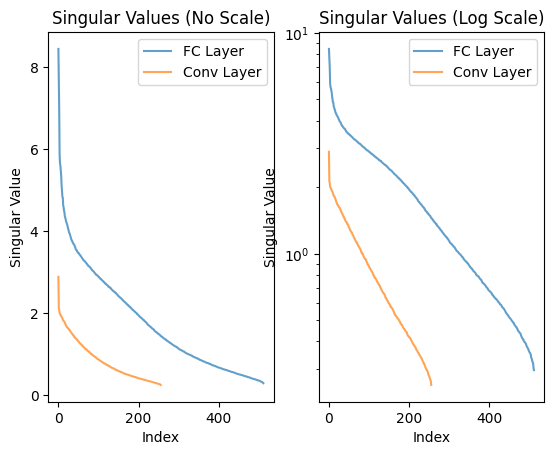

In [30]:
# Singular Values Plot (No scale)
plt.subplot(1, 2, 1)
plt.plot(s_fc, label='FC Layer', alpha=0.7)
plt.plot(s_conv, label='Conv Layer', alpha=0.7)
plt.title('Singular Values (No Scale)')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.legend()

# Singular Values Plot (log Scaled)
plt.subplot(1, 2, 2)
plt.plot(s_fc, label='FC Layer', alpha=0.7)
plt.plot(s_conv, label='Conv Layer', alpha=0.7)
plt.yscale('log')
plt.title('Singular Values (Log Scale)')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.legend()

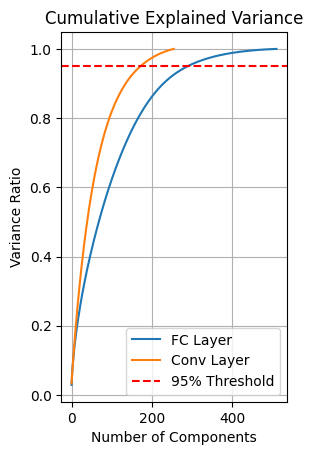

In [25]:

# Cumulative Variance Plot
plt.subplot(1, 2, 2)
plt.plot(cum_fc, label='FC Layer')
plt.plot(cum_conv, label='Conv Layer')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Variance Ratio')
plt.legend()
plt.grid(True)